In [1]:
import os
import random
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, draw_box
from torchvision import transforms, models

import time
import copy

In [ ]:
!ls

In [2]:
image_folder = 'data'
annotation_csv = 'data/annotation.csv'
# You shouldn't change the unlabeled_scene_index
# The first 106 scenes are unlabeled
unlabeled_scene_index = np.arange(106)
# The scenes from 106 - 133 are labeled
# You should devide the labeled_scene_index into two subsets (training and validation)
labeled_scene_index = np.arange(106, 134)

BATCH_SIZE = 1
transform = torchvision.transforms.Compose([
    # transforms.Resize(size=(256,256)),
    transforms.ToTensor(),
    # transforms.Normalize(img_net_mean.tolist(), img_net_std.tolist())
])

labeled_trainset = LabeledDataset(image_folder = image_folder,
                                  annotation_file = annotation_csv,
                                  scene_index = labeled_scene_index,
                                  transform = transform, 
                                  extra_info = True)



train_set, val_set = torch.utils.data.random_split(labeled_trainset, [2646, 882])

train_loader = torch.utils.data.DataLoader(train_set, batch_size =BATCH_SIZE, 
                                           shuffle = True, num_workers =2, 
                                           collate_fn = collate_fn)

val_loader = torch.utils.data.DataLoader(val_set, batch_size=BATCH_SIZE,
                                         shuffle= True, num_workers =2,
                                         collate_fn = collate_fn)

In [ ]:
sample, target, roadmap, extra = iter(train_loader).next()

In [4]:
mini_set, _ = torch.utils.data.random_split(labeled_trainset, [3, 3525])


In [5]:
mini_loader = torch.utils.data.DataLoader(mini_set, batch_size=1, shuffle = True, 
                                          num_workers=2, collate_fn = collate_fn)

In [ ]:
plt.imshow(sample[0][1].numpy().transpose(1,2,0))

In [4]:
def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace= True),
    )

def concat_features(feature_list):
    # print(len(feature_list))
    assert len(feature_list) == 6
    output = torch.cat([feature_list[i] for i in range(3)], dim=3)
    output1 = torch.cat([feature_list[i] for i in range(3, 6)], dim=3)
    return torch.cat([output, output1], dim=2)
    

class ResNetUNet2(nn.Module):
    def __init__(self):
        super().__init__()
        self.base_model = models.resnet18(pretrained=False)
        self.base_layers = list(self.base_model.children())
        
        # self.res_feature_list = []
        self.res_head = nn.Sequential(*self.base_layers[:3])
        self.res_up = nn.Upsample((400,400))
        
        self.layer0_1x1 = convrelu(64, 64,1,0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5])
        self.layer1_1x1 = convrelu(64, 64,1,0)
        self.layer2 = self.base_layers[5]
        self.layer2_1x1 = convrelu(128,128,1,0)
        self.layer3 = self.base_layers[6]
        self.layer3_1x1 = convrelu(256, 256, 1,0)
        self.layer4 = self.base_layers[7]
        self.layer4_1x1 = convrelu(512, 512, 1,0)
        
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', 
                                    align_corners=True)
        
        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)
        
        # self.orig_list = []
        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.orig_up = nn.Upsample((800,800))
        
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

        self.conv_last = nn.Sequential(
                            nn.Conv2d(64, 1, 1),
                            nn.Sigmoid())
        
        
    def forward(self, sample_input):

        #layer0 = self.layer0(input)
        res_feature_list = []
        orig_list = []
        for i in range(6):
            res_feature_list.append(self.res_head(sample_input[i].unsqueeze(0)))
            orig_list.append(self.conv_original_size0(sample_input[i].unsqueeze(0)))
    
        layer0  = self.res_up(concat_features(res_feature_list))
        #print('The layer0 shapeis ', layer0.shape)
        
        # x_original = self.conv_original_size0
        x_original = self.orig_up(concat_features(orig_list))
        #print('The original shape is ', x_original.shape)
        
        x_original = self.conv_original_size1(x_original) # 64 x 256 x 256 
        
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3) # 512 x 8x8

        layer4 = self.layer4_1x1(layer4) # 512 x 8 x 8
        x = self.upsample(layer4) # 512 x 16 x 16
        layer3 = self.layer3_1x1(layer3) # 256 x 16 x 16
        x = torch.cat([x, layer3], dim=1) # 769 x 16 x 16
        x = self.conv_up3(x) # 512 x 16 x16

        x = self.upsample(x) # 512 x 32 x32 
        layer2 = self.layer2_1x1(layer2) # 128 x 32 x 32 
        x = torch.cat([x, layer2], dim=1) # 640x 32 x 32 
        x = self.conv_up2(x) # 256 x 32 x 32

        x = self.upsample(x) # 256 x 64 x64
        layer1 = self.layer1_1x1(layer1)# 64 x 64 x 64 
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x) # 256 x 64 x 64 

        x = self.upsample(x) # 256 x 128 x 128
        layer0 = self.layer0_1x1(layer0) # 64 x 128 x 128
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)# 128 x 128 x128

        x = self.upsample(x) # 128x 256 x 256
        x = torch.cat([x, x_original], dim=1) # (64+128) x 256 x 256
        x = self.conv_original_size2(x) # 64 x 256 x 256

        out = self.conv_last(x)

        return out   
        
        

In [5]:
def dice_loss(true, preds, epsilon = 1e-4):
    sh1, sh2 = preds.size()
    true = true.view(1, -1)
    preds = preds.view(1, -1)
    prod = torch.sum(true*preds,dim = 1)
    sum_tnp = torch.sum(true + preds, dim = 1)
    num = torch.sum(prod)
    denom = torch.sum(sum_tnp) + epsilon
    loss = 1 - 2*(num/denom)

    return torch.mean(loss)

def compute_dice(true, preds, epsilon = 1e-7):
    sh1, sh2 = preds.size()
    true = true.view(1, -1)
    preds = preds.view(1, -1)
    
    prod = torch.sum(true*preds,dim = 1)
    sum_tnp = torch.sum(true + preds, dim = 1)
    
    num = torch.sum(prod)
    denom = torch.sum(sum_tnp) + epsilon

    return torch.mean(num/denom)

In [ ]:
test_net = ResNetUNet2().to(device)
test_output = test_net(sample[0])

In [ ]:
test_output.squeeze().shape

In [ ]:
# test for lost function
dice_loss(roadmap[0], test_output.squeeze())

In [ ]:
compute_dice(roadmap[0], test_output.squeeze())

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [7]:
device

device(type='cuda')

In [ ]:
## single data to verify the model is working

In [ ]:
plt.imshow(roadmap[0].numpy())

In [ ]:
rotated = torch.rot90(roadmap[0].int(), 1, [0,1])
plt.imshow(rotated.numpy())

In [8]:
def train_model(model, dataloader, criterion, optimizer, num_epochs):
    start_time = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    
    dice_dict={'train':[], 'eval':[]}
    loss_dict = {'train':[], 'eval':[]}
    
    for epoch in range(num_epochs):
        epoch_start = time.time()
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-'*10)

        
        for phase in ['train']:
            
            model.train()
            curr_loss = 0.0
            curr_dice = 0.0
            
            for i, (sample, target, roadmap, extra) in enumerate(dataloader):
                
                target = torch.rot90(roadmap[0].int(), 1, [0,1]).type(torch.LongTensor).to(device)
                inputs = sample[0].type(torch.FloatTensor).to(device)
                
                # print('the input size is ', inputs.shape)
                
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase=='train'):
                    output = model(inputs)
                    loss = criterion(target.cpu(), output.cpu().squeeze())

                    loss.backward()
                    optimizer.step()
                with torch.no_grad():
                    dice_score = compute_dice(target.cpu(), output.cpu().squeeze())

                curr_loss += loss.item()
                curr_dice += dice_score
                
            # After 1 epoch record the lsos    
            loss_dict['train'].append(curr_loss/len(dataloader))
            dice_dict['train'].append(curr_dice/len(dataloader))

            print('current epoch dice loss is', curr_loss)
            print('current epoch dice is ', curr_dice)
            print('Training 1 epoch takes ', time.time() - epoch_start)
        
    print('This training takes ', time.time() - start_time)
    
    fig = plt.figure()
    plt.plot(loss_dict['train'])
    plt.title('Loss per epoch')
    plt.show()
    
    fig = plt.figure()
    plt.plot(dice_dict['train'])
    plt.title('Dice per epoch')
    plt.show()
    
    return model, loss_dict, dice_dict
    
    
    

In [25]:
mynet = ResNetUNet2().to(device)
optimizer = torch.optim.Adam(mynet.parameters(), lr=1e-4)


Epoch 1/30
----------
the input size is  torch.Size([6, 3, 256, 306])
6
6
the input size is  torch.Size([6, 3, 256, 306])
6
6
the input size is  torch.Size([6, 3, 256, 306])
6
6
current epoch dice loss is 1.6456329226493835
current epoch dice is  tensor(0.6772)
Epoch 2/30
----------
the input size is  torch.Size([6, 3, 256, 306])
6
6
the input size is  torch.Size([6, 3, 256, 306])
6
6
the input size is  torch.Size([6, 3, 256, 306])
6
6
current epoch dice loss is 1.483009397983551
current epoch dice is  tensor(0.7585)
Epoch 3/30
----------
the input size is  torch.Size([6, 3, 256, 306])
6
6
the input size is  torch.Size([6, 3, 256, 306])
6
6
the input size is  torch.Size([6, 3, 256, 306])
6
6
current epoch dice loss is 1.1922879219055176
current epoch dice is  tensor(0.9039)
Epoch 4/30
----------
the input size is  torch.Size([6, 3, 256, 306])
6
6
the input size is  torch.Size([6, 3, 256, 306])
6
6
the input size is  torch.Size([6, 3, 256, 306])
6
6
current epoch dice loss is 1.19165998

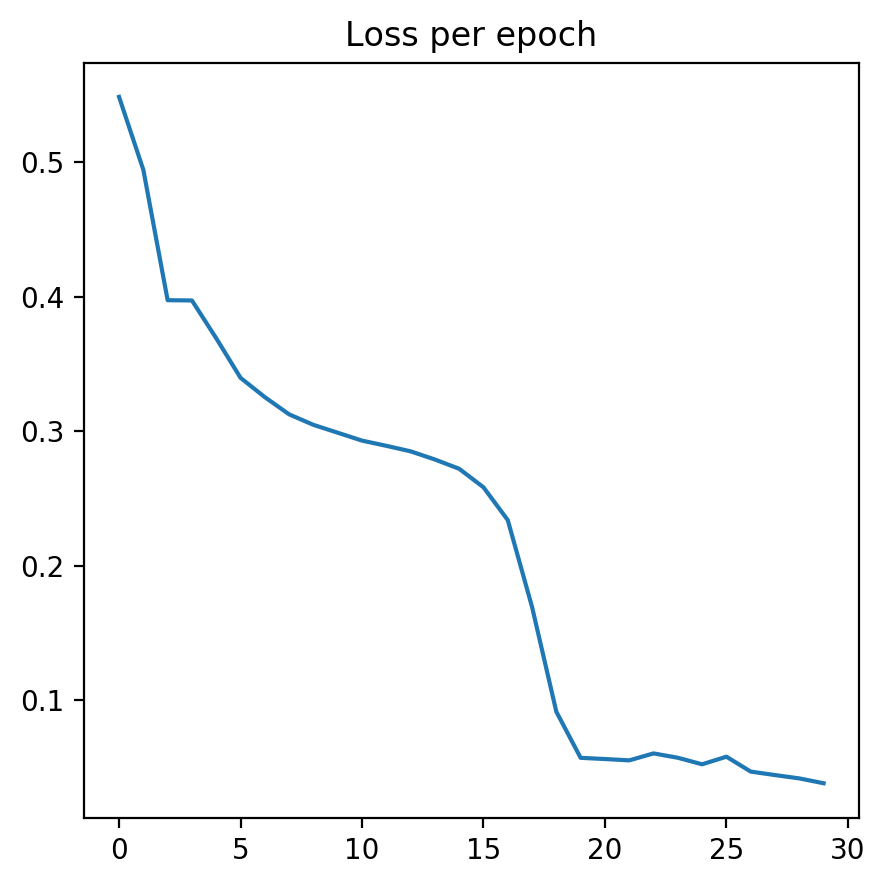

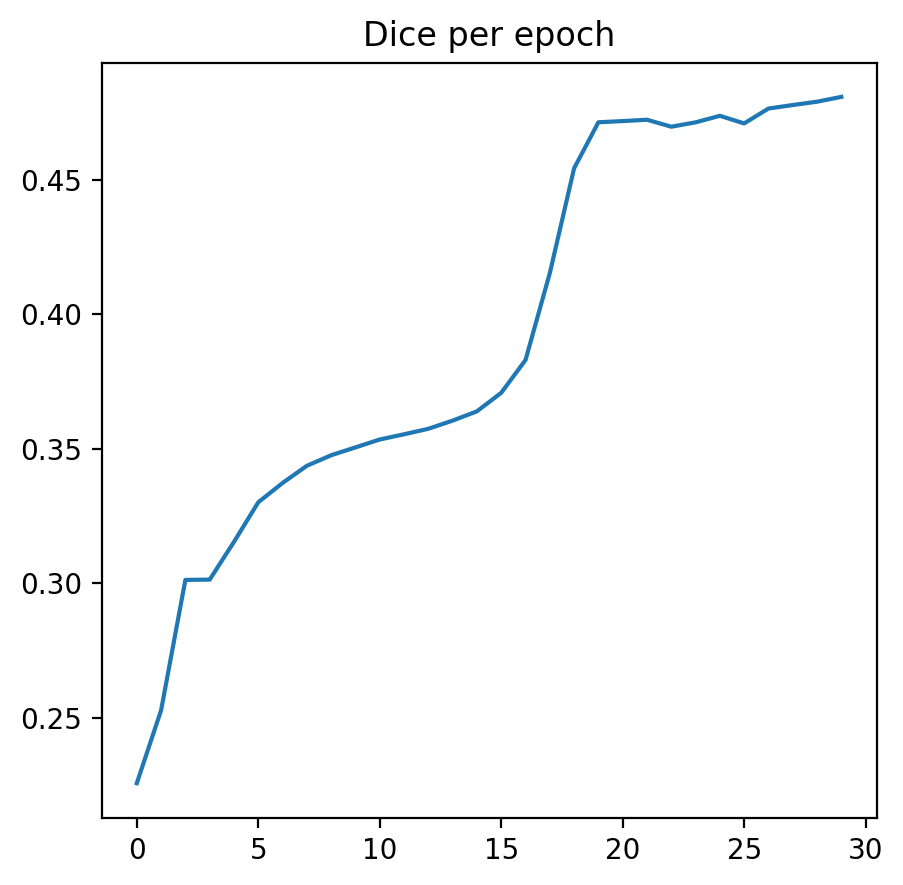

In [26]:
# Test out on mini trainloader
model, loss_dict, dice_dict = train_model(mynet, mini_loader, 
                                          dice_loss, optimizer, 30)

In [41]:
# train w/o previous weights
mynet = ResNetUNet2().to(device)

for param in mynet.parameters():
    param.requires_grad = True

Epoch 1/30
----------
current epoch dice loss is 1.6746410131454468
current epoch dice is  tensor(0.6627)
Training 1 epoch takes  0.8045072555541992
Epoch 2/30
----------
current epoch dice loss is 1.5660712718963623
current epoch dice is  tensor(0.7170)
Training 1 epoch takes  0.7963979244232178
Epoch 3/30
----------
current epoch dice loss is 1.3137309551239014
current epoch dice is  tensor(0.8431)
Training 1 epoch takes  0.7970573902130127
Epoch 4/30
----------
current epoch dice loss is 1.2516587376594543
current epoch dice is  tensor(0.8742)
Training 1 epoch takes  0.8037979602813721
Epoch 5/30
----------
current epoch dice loss is 1.2603226900100708
current epoch dice is  tensor(0.8698)
Training 1 epoch takes  0.8015315532684326
Epoch 6/30
----------
current epoch dice loss is 1.2613388895988464
current epoch dice is  tensor(0.8693)
Training 1 epoch takes  0.7992041110992432
Epoch 7/30
----------
current epoch dice loss is 1.2613244652748108
current epoch dice is  tensor(0.8693)


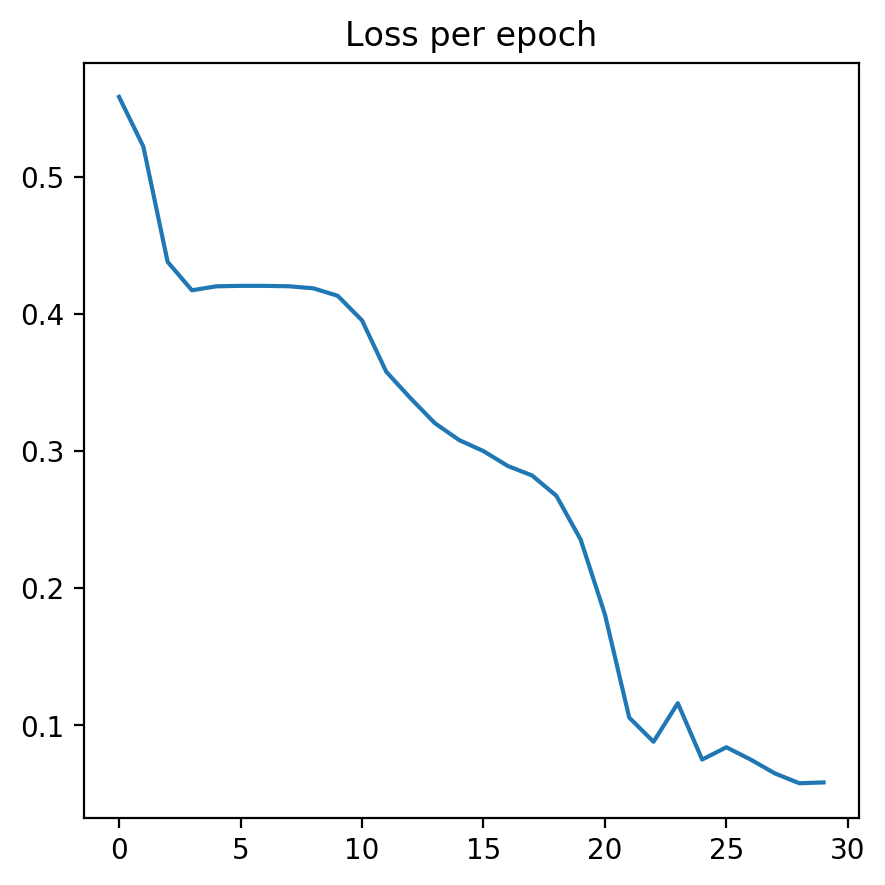

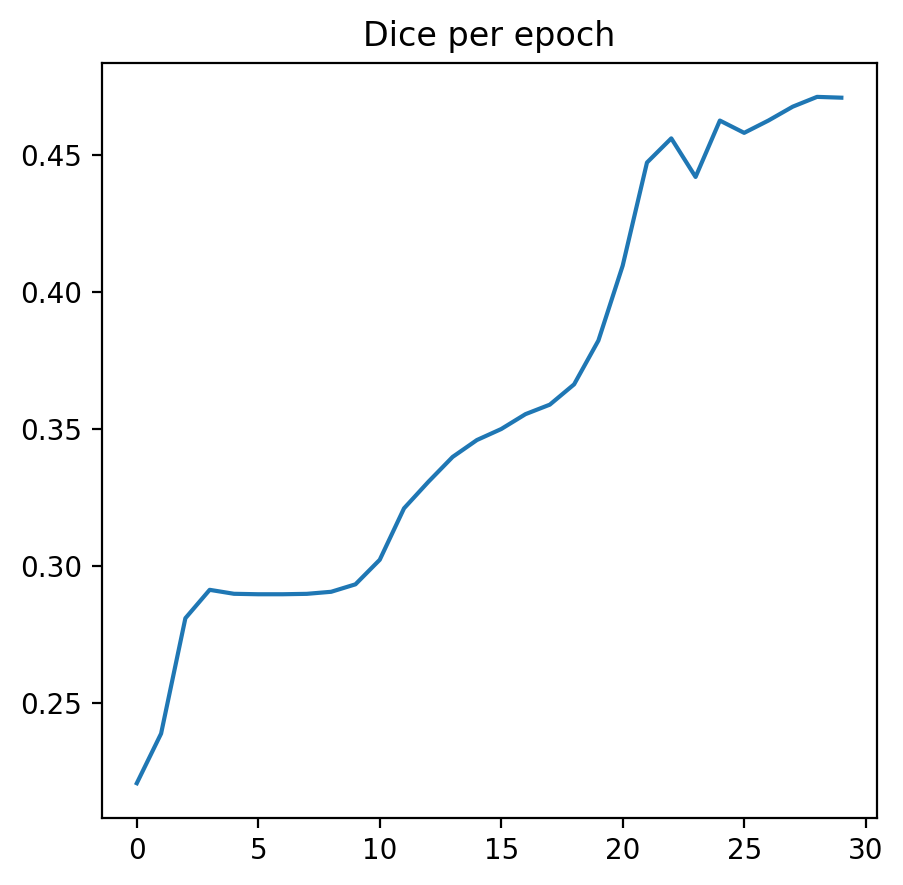

In [42]:
optimizer = torch.optim.Adam(mynet.parameters(), lr=1e-4)

# Test out on mini trainloader
model, loss_dict, dice_dict = train_model(mynet, mini_loader, 
                                          dice_loss, optimizer, 30)



In [9]:
# train w/o previous weights
mynet = ResNetUNet2().to(device)

for param in mynet.parameters():
    param.requires_grad = True
    
    

Epoch 1/15
----------
current epoch dice loss is 964.6338251829147
current epoch dice is  tensor(840.6834)
Training 1 epoch takes  475.82015013694763
Epoch 2/15
----------
current epoch dice loss is 556.3092471957207
current epoch dice is  tensor(1044.8462)
Training 1 epoch takes  497.81524324417114
Epoch 3/15
----------
current epoch dice loss is 548.3060185909271
current epoch dice is  tensor(1048.8462)
Training 1 epoch takes  490.2160747051239
Epoch 4/15
----------
current epoch dice loss is 539.7526707053185
current epoch dice is  tensor(1053.1226)
Training 1 epoch takes  498.8770694732666
Epoch 5/15
----------
current epoch dice loss is 529.1450297236443
current epoch dice is  tensor(1058.4276)
Training 1 epoch takes  501.16077399253845
Epoch 6/15
----------
current epoch dice loss is 509.6631885766983
current epoch dice is  tensor(1068.1678)
Training 1 epoch takes  499.07189679145813
Epoch 7/15
----------
current epoch dice loss is 486.31029665470123
current epoch dice is  tensor

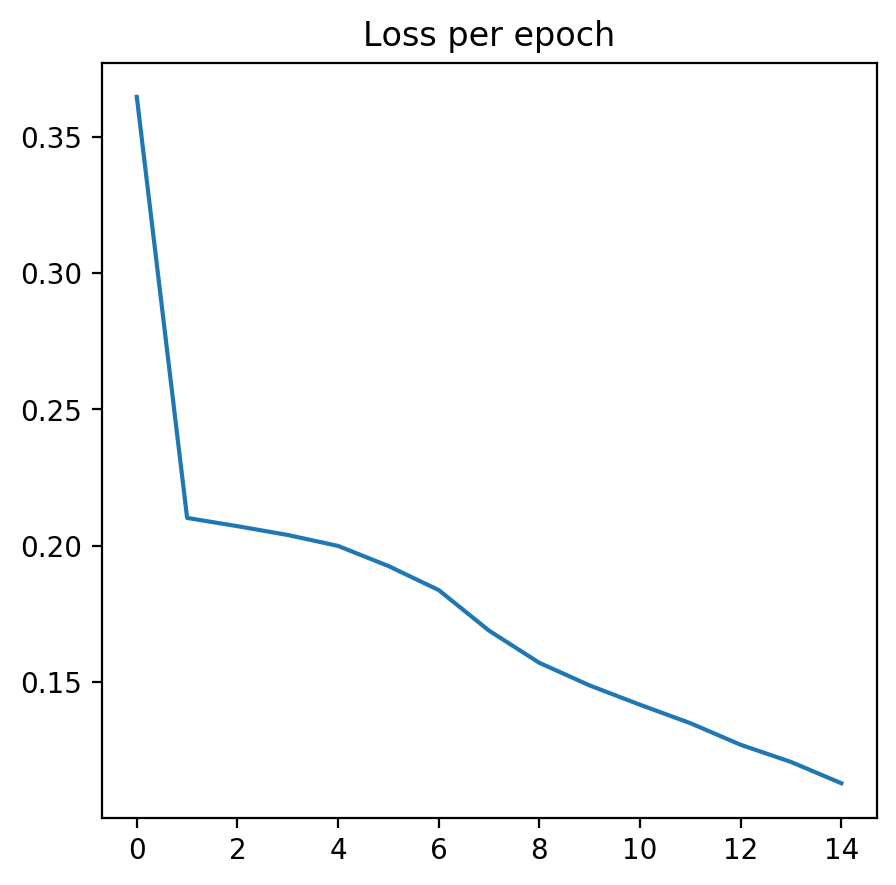

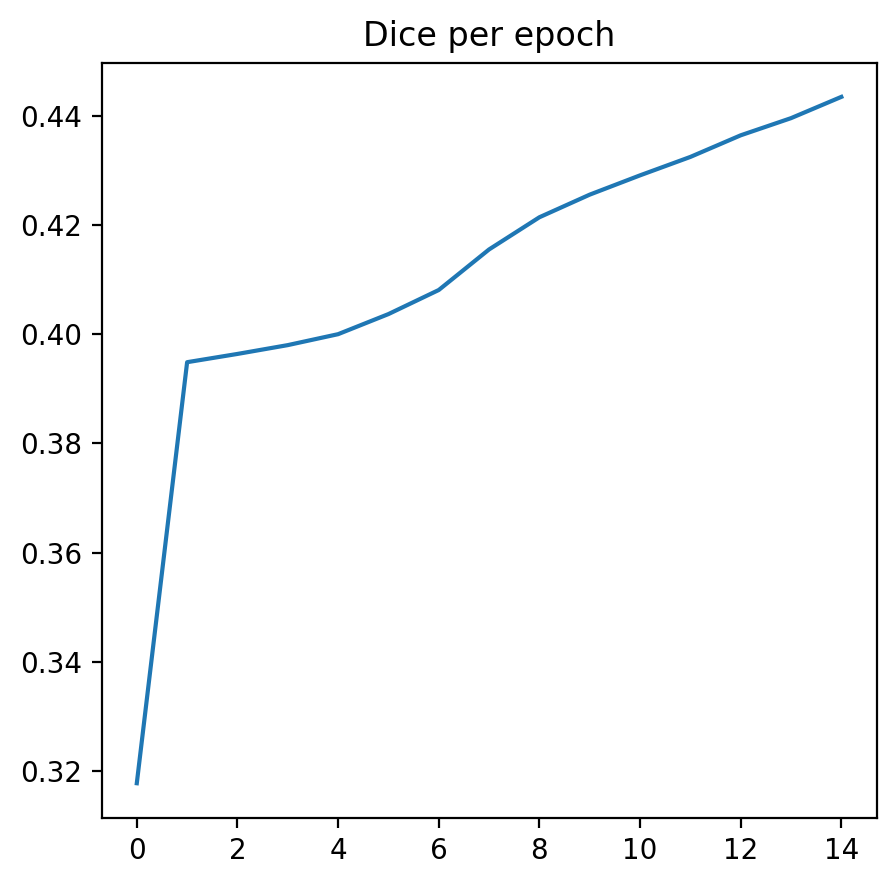

In [10]:
optimizer = torch.optim.Adam(mynet.parameters(), lr=1e-4)

# Test out on mini trainloader
model, loss_dict, dice_dict = train_model(mynet, train_loader, 
                                          dice_loss, optimizer, 15)



In [17]:
len(val_set[0][0])

6

In [22]:
len(val_set[3])

4

In [23]:
inputs = val_set[3][0].cuda()
outputs = model(inputs).cpu().squeeze().detach()

In [25]:
outputs = torch.rot90(outputs, -1, [0,1])

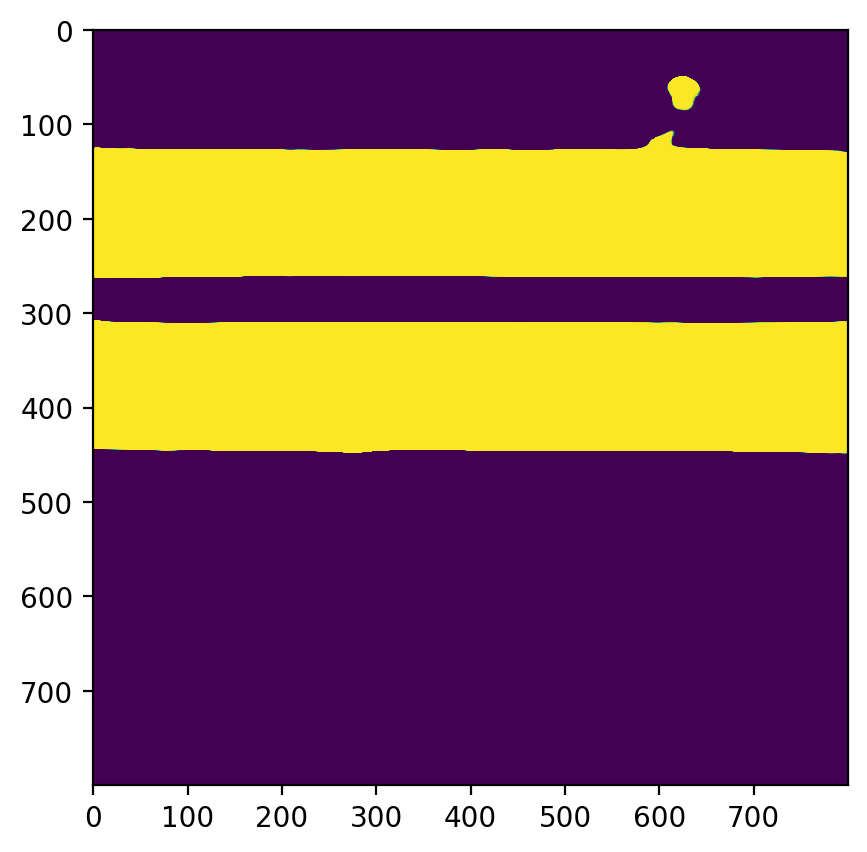

In [26]:
plt.imshow(outputs.numpy())

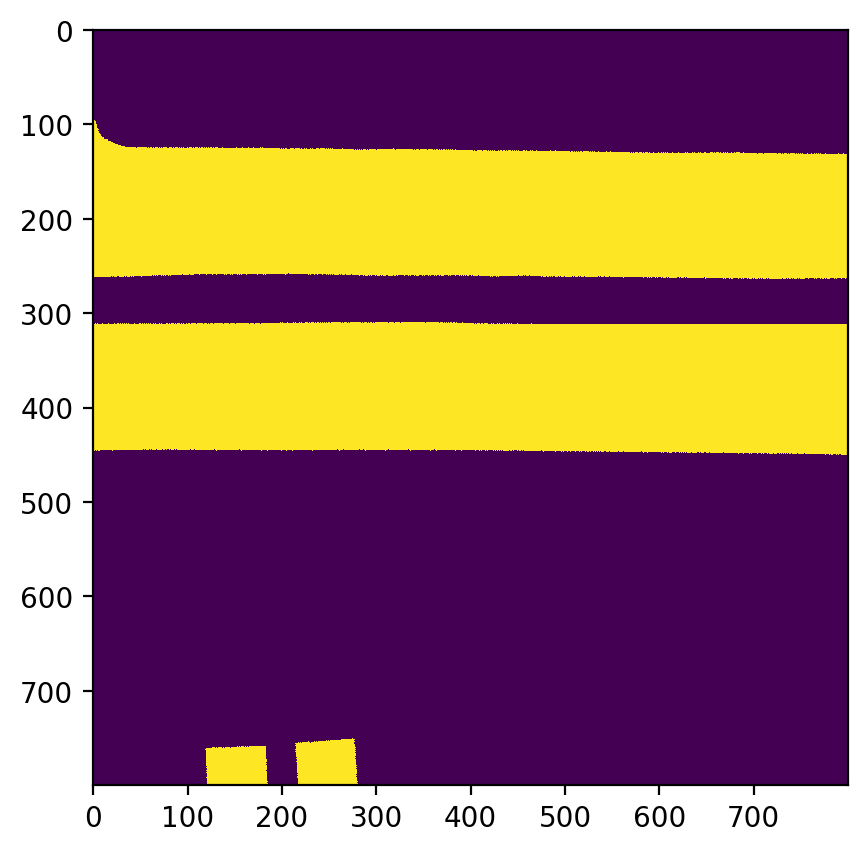

In [27]:
plt.imshow(val_set[3][2].cpu().numpy())

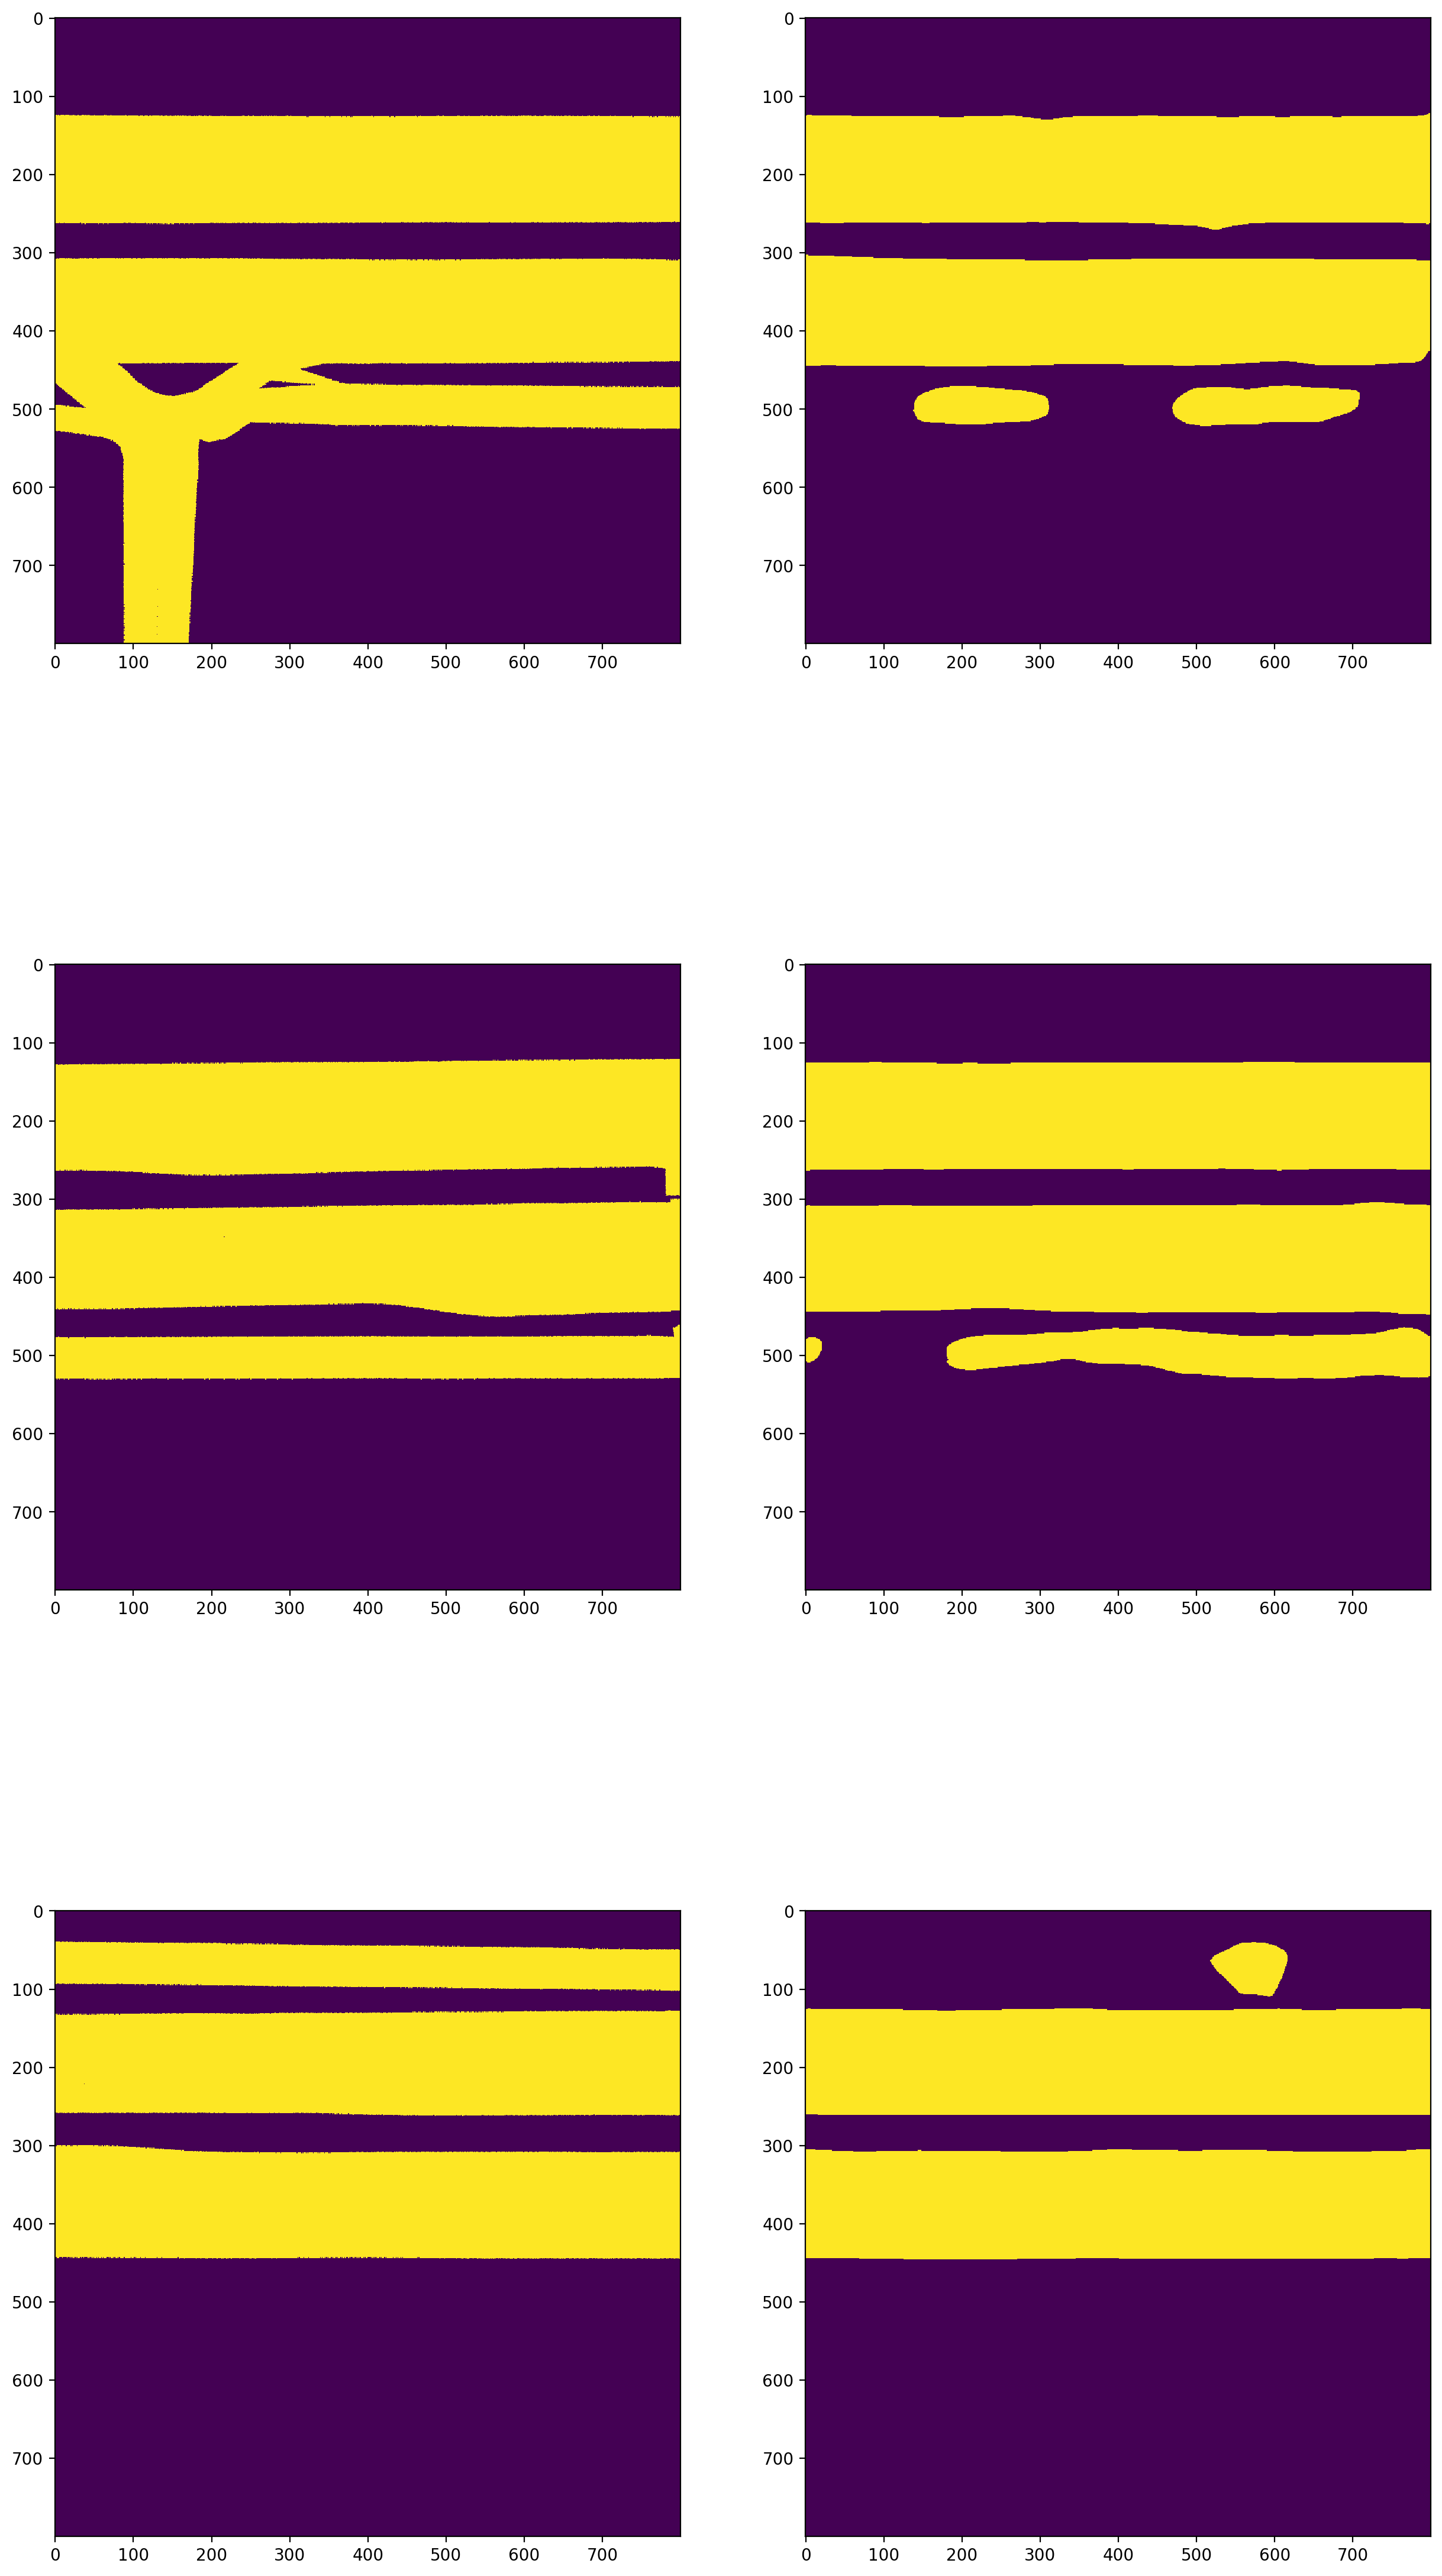

In [29]:
fig, ax = plt.subplots(3, 2, figsize=(15,30))
for i in range(3):
    inputs = val_set[i][0].cuda()
    
    outputs = model(inputs).cpu().squeeze().detach()
    
    outputs = torch.rot90(outputs, -1, [0,1])
    ax[i, 0].imshow(val_set[i][2].cpu().numpy())
    ax[i,1].imshow((outputs>0.5).numpy())
    
    
    
    

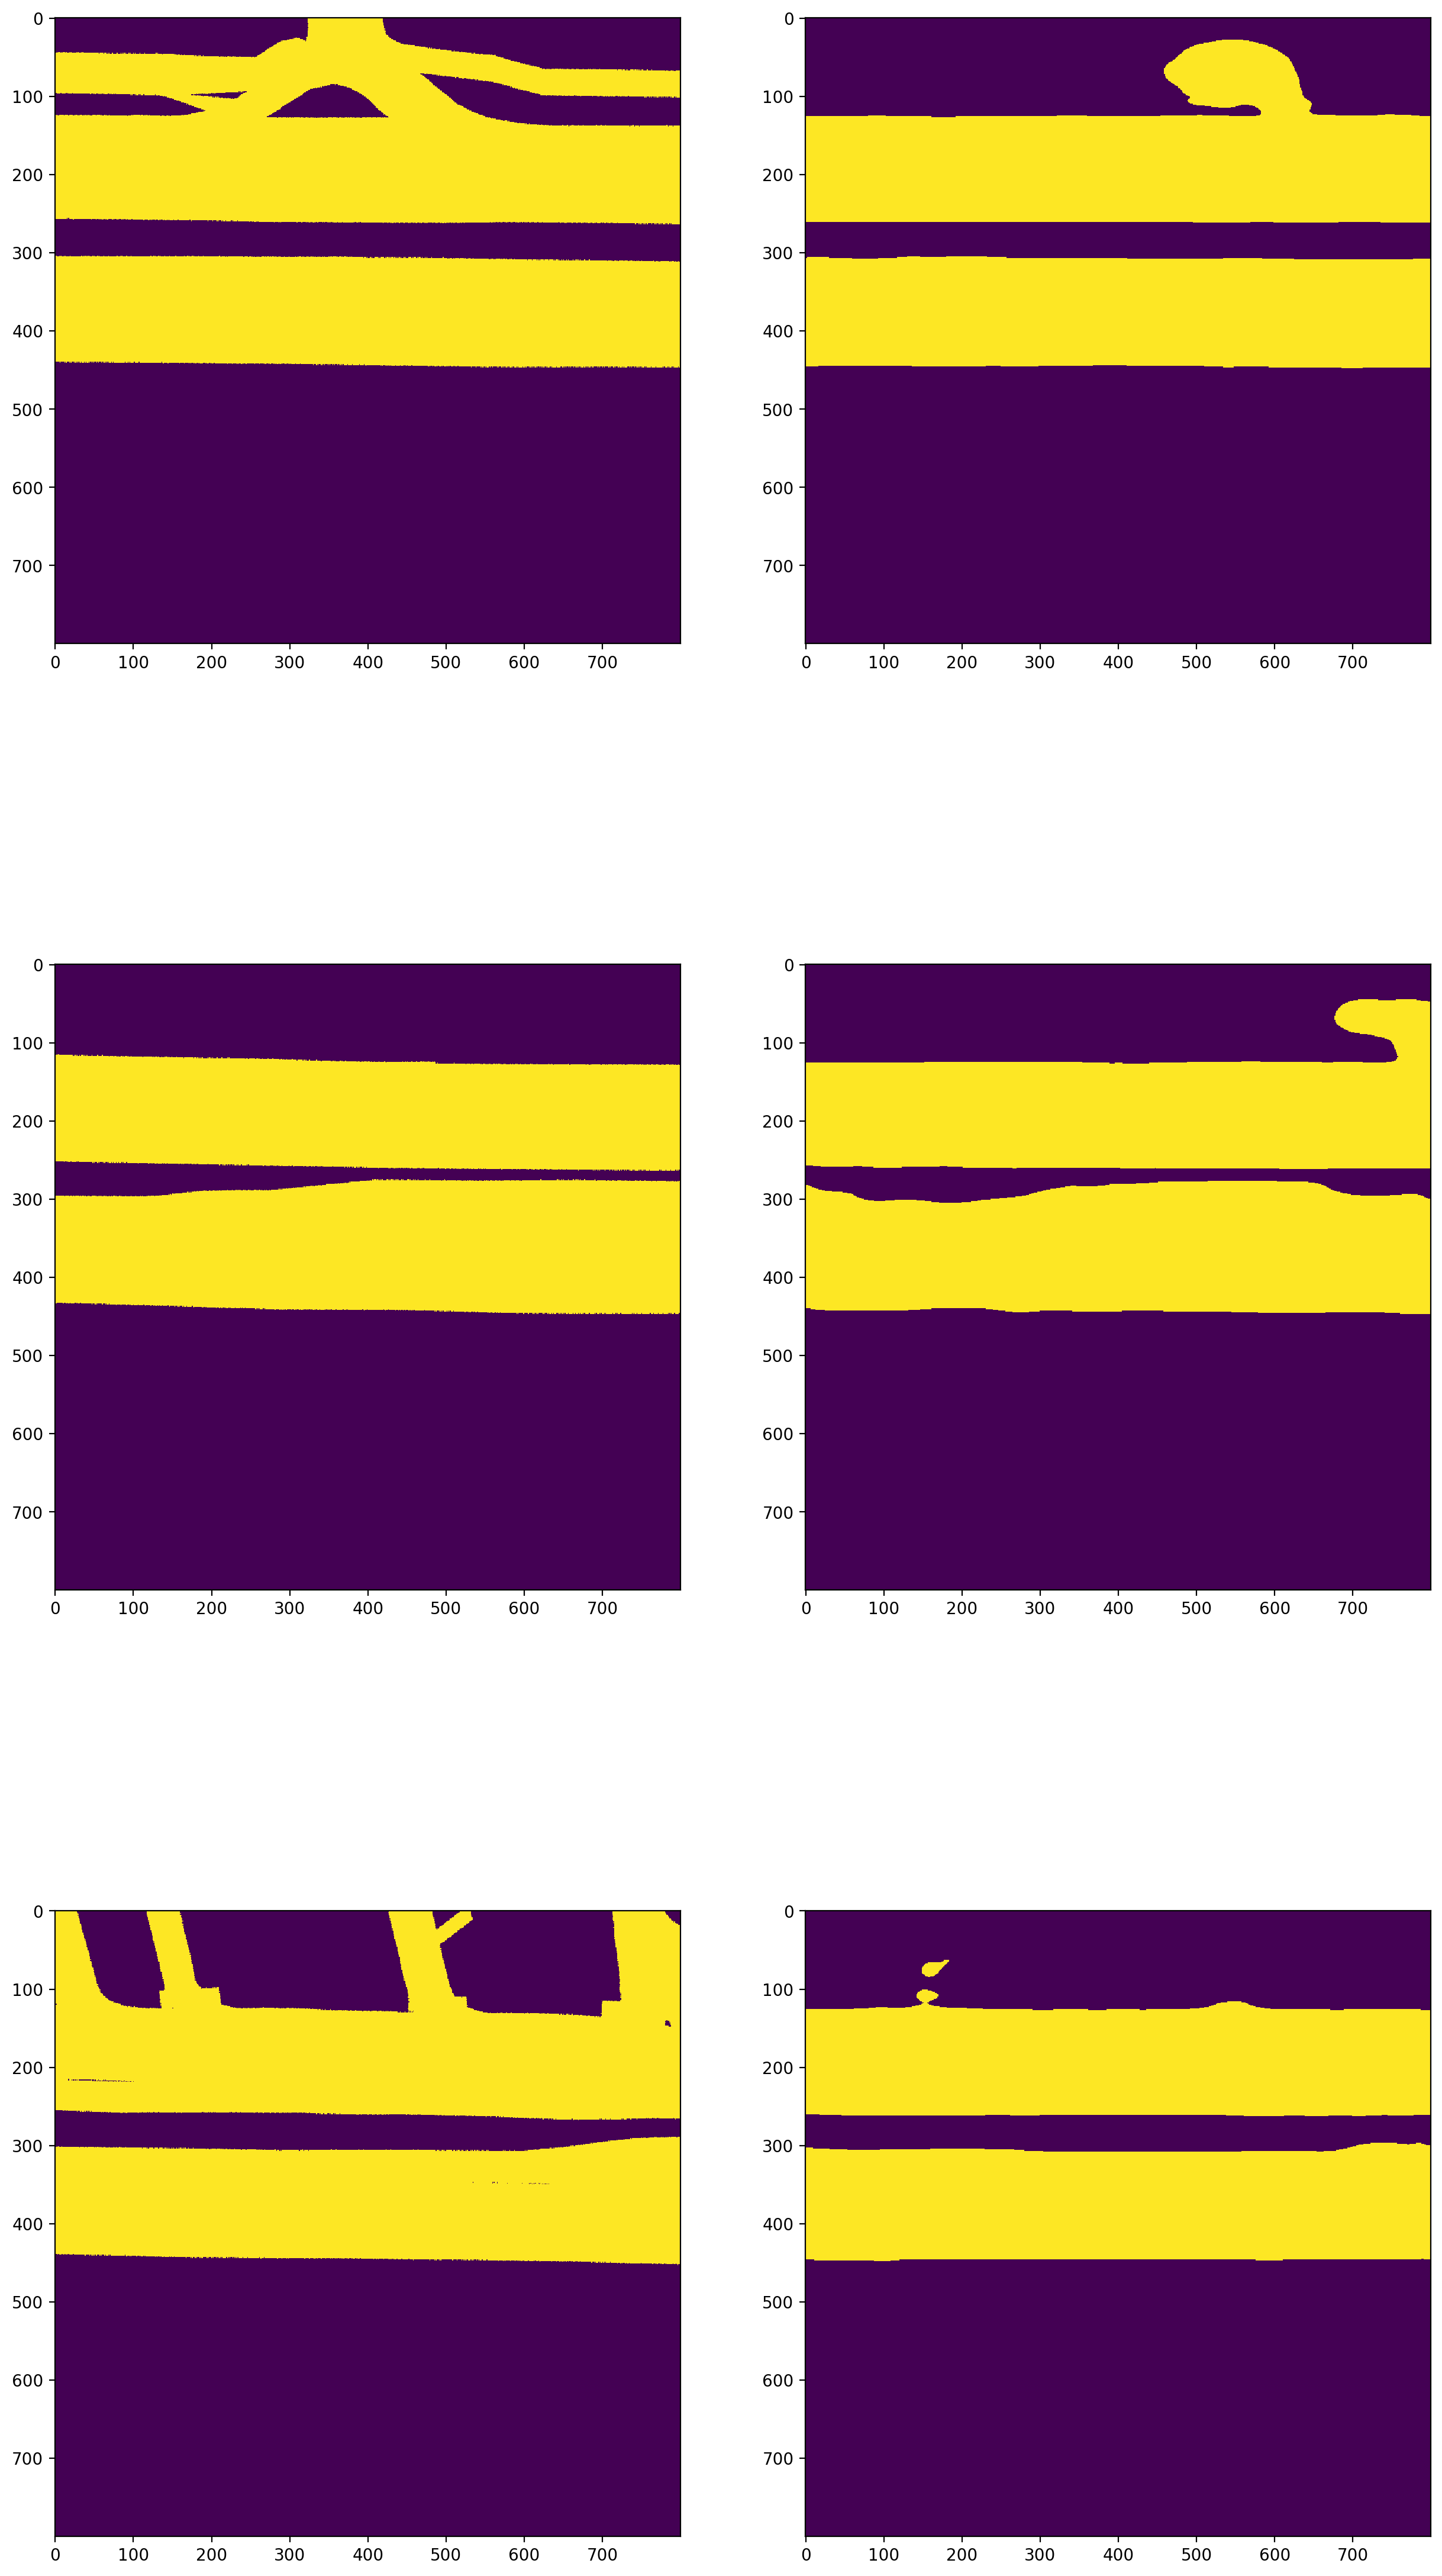

In [30]:
fig, ax = plt.subplots(3, 2, figsize=(15,30))
for i in range(400,403):
    inputs = val_set[i][0].cuda()
    
    outputs = model(inputs).cpu().squeeze().detach()
    
    outputs = torch.rot90(outputs, -1, [0,1])
    ax[i-400, 0].imshow(val_set[i][2].cpu().numpy())
    ax[i-400,1].imshow((outputs>0.5).numpy())
    
    
    
    

In [32]:
torch.save(model.state_dict(), '/scratch/ht1162/DLSP20Dataset/res18_unet.pth')